# Huấn luyện mô hình phân loại trạng thái từ dữ liệu sensor

Notebook này được tạo ra để huấn luyện một mô hình phân loại trạng thái (nghỉ ngơi, ngồi, đi bộ) từ dữ liệu sensor quang phản xạ đo nhịp tim và SpO2.


In [2]:
# Cài đặt các thư viện cần thiết
%pip install numpy pandas matplotlib seaborn scipy scikit-learn tensorflow joblib

Note: you may need to restart the kernel to use updated packages.


## 1. Import thư viện cần thiết


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import joblib
import gc
import random

# Thiết lập để hiển thị đồ thị trong notebook
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Thiết lập ngẫu nhiên để kết quả có thể tái tạo
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## 2. Phân tích bộ nhớ sử dụng

Theo yêu cầu, bộ nhớ cho mô hình phải giới hạn trong 3000 objects, mỗi object gồm 3 giá trị uint32_t. Hãy tính xem điều này có nghĩa là gì về mặt kích thước và số lượng tham số mô hình.


In [4]:
# Phân tích giới hạn bộ nhớ
uint32_size_bytes = 4  # 4 bytes cho mỗi uint32_t
object_size_bytes = uint32_size_bytes * 3  # Mỗi object có 3 giá trị uint32_t
max_objects = 3000
total_bytes_limit = max_objects * object_size_bytes

print(f"Kích thước mỗi object: {object_size_bytes} bytes")
print(f"Số lượng object tối đa: {max_objects}")
print(
    f"Tổng giới hạn bộ nhớ: {total_bytes_limit} bytes = {total_bytes_limit/1024:.2f} KB")

# Một float32 trong TensorFlow cũng chiếm 4 bytes, tương đương với uint32_t
max_model_params = 3000 * 3
print(f"Số lượng tham số tối đa trong mô hình: {max_model_params}")

Kích thước mỗi object: 12 bytes
Số lượng object tối đa: 3000
Tổng giới hạn bộ nhớ: 36000 bytes = 35.16 KB
Số lượng tham số tối đa trong mô hình: 9000


## 3. Tải và phân tích dữ liệu

Tải các file dữ liệu từ các trạng thái khác nhau (nghỉ ngơi, ngồi, đi bộ).


In [5]:
# Đường dẫn đến các file dữ liệu
data_dir = 'dataC/data/csv/'
resting_file = os.path.join(data_dir, 'resting_train.csv')
sitting_file = os.path.join(data_dir, 'sitting_train.csv')
walking_files = [
    os.path.join(data_dir, 'walk1_train.csv'),
    os.path.join(data_dir, 'walk2_train.csv'),
    os.path.join(data_dir, 'walk3_train.csv')
]

# Kiểm tra các file có tồn tại không
all_files = [resting_file, sitting_file] + walking_files
missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print(f"Không tìm thấy các file: {missing_files}")
    # Thử tìm trong thư mục gốc
    data_dir = './'
    resting_file = os.path.join(data_dir, 'resting_train.csv')
    sitting_file = os.path.join(data_dir, 'sitting_train.csv')
    walking_files = [
        os.path.join(data_dir, 'walk1_train.csv'),
        os.path.join(data_dir, 'walk2_train.csv'),
        os.path.join(data_dir, 'walk3_train.csv')
    ]

# Hàm đọc dữ liệu


def load_data(file_path, label):
    try:
        df = pd.read_csv(file_path)
        df['label'] = label
        return df
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}")
        return None


# Đọc dữ liệu
resting_data = load_data(resting_file, 'resting')
sitting_data = load_data(sitting_file, 'sitting')
walking_data = pd.concat([load_data(file, 'walking')
                         for file in walking_files if load_data(file, 'walking') is not None])

# Hiển thị thông tin về dữ liệu
print(
    f"Dữ liệu nghỉ ngơi: {resting_data.shape if resting_data is not None else 'None'}")
print(
    f"Dữ liệu ngồi: {sitting_data.shape if sitting_data is not None else 'None'}")
print(
    f"Dữ liệu đi bộ: {walking_data.shape if walking_data is not None else 'None'}")

Dữ liệu nghỉ ngơi: (5999, 5)
Dữ liệu ngồi: (5999, 5)
Dữ liệu đi bộ: (17988, 5)


### 3.1. Phân tích thống kê dữ liệu


In [6]:
# Phân tích thống kê dữ liệu
def analyze_data(data, title):
    if data is None:
        print(f"Không có dữ liệu {title}")
        return

    print(f"\n=== Phân tích dữ liệu {title} ===")
    print(f"Số lượng mẫu: {data.shape[0]}")
    print(f"Thống kê mô tả:")
    print(data[['ir', 'red']].describe())

    # Kiểm tra giá trị thiếu
    missing = data.isnull().sum()
    if missing.sum() > 0:
        print(f"Giá trị thiếu:\n{missing}")
    else:
        print("Không có giá trị thiếu.")


# Phân tích từng bộ dữ liệu
analyze_data(resting_data, "nghỉ ngơi")
analyze_data(sitting_data, "ngồi")
analyze_data(walking_data, "đi bộ")


=== Phân tích dữ liệu nghỉ ngơi ===
Số lượng mẫu: 5999
Thống kê mô tả:
                  ir            red
count    5999.000000    5999.000000
mean   108674.282714  103378.254709
std      2324.529979    1218.467922
min    102816.000000  100701.000000
25%    107437.500000  102653.500000
50%    108424.000000  103190.000000
75%    109341.000000  103756.000000
max    115324.000000  108017.000000
Không có giá trị thiếu.

=== Phân tích dữ liệu ngồi ===
Số lượng mẫu: 5999
Thống kê mô tả:
                  ir            red
count    5999.000000    5999.000000
mean   114602.894316  104667.364227
std       653.317385     370.865699
min    112355.000000  103570.000000
25%    114160.000000  104427.000000
50%    114720.000000  104647.000000
75%    115160.500000  104876.000000
max    115593.000000  105953.000000
Không có giá trị thiếu.

=== Phân tích dữ liệu đi bộ ===
Số lượng mẫu: 17988
Thống kê mô tả:
                  ir            red
count   17988.000000   17988.000000
mean   110453.611074  10

### 3.2. Vẽ đồ thị mẫu dữ liệu từ mỗi nhãn


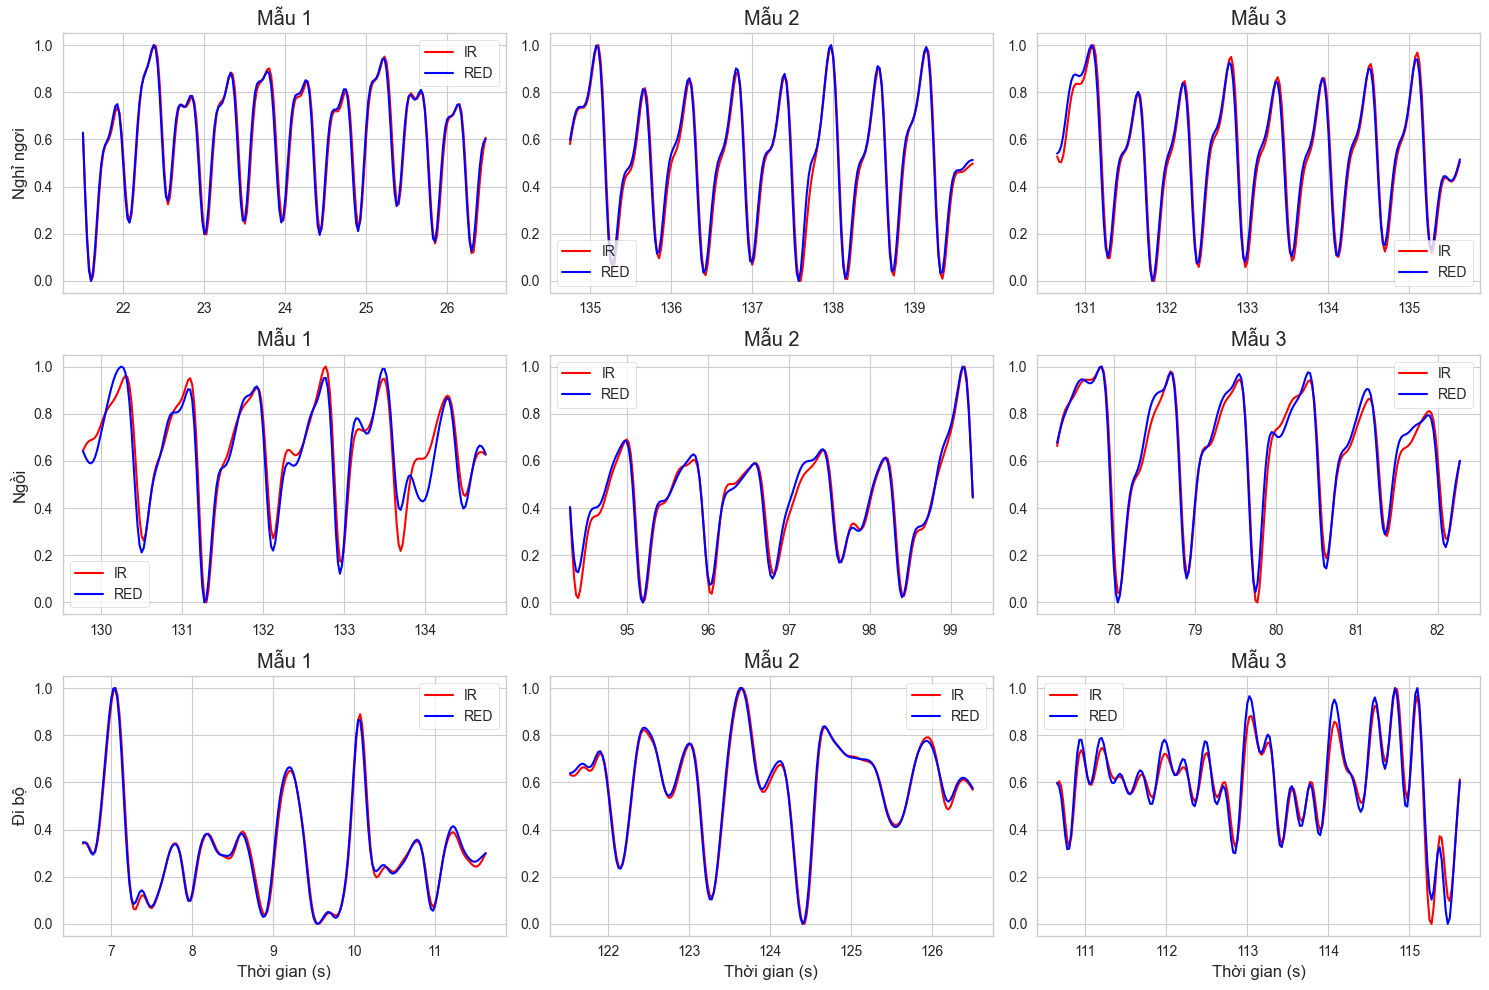

In [7]:
# Hàm để lọc dữ liệu theo dải tần số quan tâm
def butter_bandpass_filter(data, lowcut=0.5, highcut=4.0, fs=40.0, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Hàm chuẩn hóa dữ liệu


def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# Hàm vẽ đồ thị mẫu ngẫu nhiên từ mỗi nhãn


def plot_random_samples(datasets, labels, num_samples=3, window_size=200):
    fig, axes = plt.subplots(len(datasets), num_samples, figsize=(15, 10))

    for i, (data, label) in enumerate(zip(datasets, labels)):
        if data is None:
            continue

        for j in range(num_samples):
            # Chọn một điểm bắt đầu ngẫu nhiên
            if len(data) > window_size:
                start_idx = np.random.randint(0, len(data) - window_size)
                sample = data.iloc[start_idx:start_idx+window_size]
            else:
                sample = data

            # Lọc và chuẩn hóa tín hiệu
            ir_filtered = butter_bandpass_filter(sample['ir'].values)
            red_filtered = butter_bandpass_filter(sample['red'].values)
            ir_norm = normalize_signal(ir_filtered)
            red_norm = normalize_signal(red_filtered)

            # Vẽ đồ thị
            ax = axes[i, j]
            ax.plot(sample['time_delta'].values, ir_norm, 'r-', label='IR')
            ax.plot(sample['time_delta'].values, red_norm, 'b-', label='RED')
            if j == 0:
                ax.set_ylabel(label)
            if i == len(datasets) - 1:
                ax.set_xlabel('Thời gian (s)')
            ax.set_title(f'Mẫu {j+1}')
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()


# Vẽ mẫu ngẫu nhiên từ mỗi nhãn
plot_random_samples(
    [resting_data, sitting_data, walking_data],
    ['Nghỉ ngơi', 'Ngồi', 'Đi bộ'],
    num_samples=3
)

## 4. Tiền xử lý dữ liệu

Chuẩn bị dữ liệu cho quá trình huấn luyện mô hình bằng cách cắt thành các đoạn 200 giá trị.


In [8]:
# Thiết lập các tham số cho tiền xử lý dữ liệu
WINDOW_SIZE = 100  # Số lượng giá trị mỗi đoạn
STEP_SIZE = 20     # Bước nhảy giữa các đoạn liên tiếp


def create_segments(df, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    """Tạo các đoạn dữ liệu có độ dài window_size với bước nhảy step_size"""
    if df is None:
        return [], []

    segments = []
    labels = []
    label = df['label'].iloc[0]

    for i in range(0, len(df) - window_size, step_size):
        ir_segment = df['ir'].iloc[i:i+window_size].values
        red_segment = df['red'].iloc[i:i+window_size].values

        # Tiền xử lý (chuẩn hóa)
        ir_segment = (ir_segment - np.mean(ir_segment)) / np.std(ir_segment)
        red_segment = (red_segment - np.mean(red_segment)) / \
            np.std(red_segment)

        # Kết hợp ir và red thành 1 đoạn dữ liệu
        segment = np.column_stack((ir_segment, red_segment))
        segments.append(segment)
        labels.append(label)

    return np.array(segments), np.array(labels)


# Tạo dữ liệu segments cho từng trạng thái
resting_segments, resting_labels = create_segments(resting_data)
sitting_segments, sitting_labels = create_segments(sitting_data)
walking_segments, walking_labels = create_segments(walking_data)

# Kết hợp tất cả dữ liệu
X = np.concatenate(
    (resting_segments, sitting_segments, walking_segments), axis=0)
y = np.concatenate((resting_labels, sitting_labels, walking_labels), axis=0)

# Mã hóa nhãn
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Kích thước dữ liệu huấn luyện: {X_train.shape}")
print(f"Kích thước dữ liệu kiểm tra: {X_test.shape}")
print(f"Các nhãn: {label_encoder.classes_}")

Kích thước dữ liệu huấn luyện: (1188, 100, 2)
Kích thước dữ liệu kiểm tra: (297, 100, 2)
Các nhãn: ['resting' 'sitting' 'walking']


## 5. Xây dựng mô hình

Xây dựng mô hình với số lượng tham số giới hạn theo yêu cầu.


In [9]:
def count_params(model):
    """Đếm số lượng tham số của mô hình"""
    return np.sum([np.prod(v.shape) for v in model.trainable_weights])


def create_model(input_shape, num_classes, max_params=9000):
    """Tạo mô hình CNN 1D với số lượng tham số giới hạn"""
    model = Sequential([
        Conv1D(
            10,
            kernel_size=5,
            activation="relu",
            input_shape=input_shape,
            padding="same",
        ),


        MaxPooling1D(pool_size=2),
        Conv1D(10, kernel_size=5, activation="relu", padding="same"),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(21, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ])
    total_params = count_params(model)

    print(f"Tổng số tham số: {total_params}")

    if total_params > max_params:
        print(


            f"Cảnh báo: Số lượng tham số ({total_params}) vượt quá giới hạn ({max_params})"
        )
    return model


# Tạo và biên dịch mô hình
# (window_size, features) - 2 features là ir và red
input_shape = (WINDOW_SIZE, 2)

num_classes = len(np.unique(y_encoded))

model = create_model(input_shape, num_classes, max_params=9000)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],


)

# Hiển thị tổng quan về mô hình

model.summary()

Tổng số tham số: 5957


d:\Deadline\Nhung\OxiSensor\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 10)        │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 10)         │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │         5,271 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957 (23.27 KB)

 Trainable params: 5,957 (23.27 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Huấn luyện mô hình


In [10]:
# Thiết lập callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5125 - loss: 1.0493
Epoch 1: val_accuracy improved from -inf to 0.60504, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5141 - loss: 1.0481 - val_accuracy: 0.6050 - val_loss: 0.9311
Epoch 2/50
16/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6163 - loss: 0.9090 
Epoch 2: val_accuracy improved from 0.60504 to 0.65966, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6097 - loss: 0.9058 - val_accuracy: 0.6597 - val_loss: 0.8404
Epoch 3/50
17/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6538 - loss: 0.7971 
Epoch 3: val_accuracy improved from 0.65966 to 0.68908, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6512 - loss: 0.7921 - val_accuracy: 0.6891 - val_loss: 0.6865
Epoch 4/50
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7459 - loss: 0.6135 
Epoch 4: val_accuracy improved from 0.68908 to 0.81513, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7579 - loss: 0.6042 - val_accuracy: 0.8151 - val_loss: 0.4790
Epoch 5/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8823 - loss: 0.3880 
Epoch 5: val_accuracy improved from 0.81513 to 0.93277, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8819 - loss: 0.3857 - val_accuracy: 0.9328 - val_loss: 0.3042
Epoch 6/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9495 - loss: 0.2340 
Epoch 6: val_accuracy improved from 0.93277 to 0.95378, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9439 - loss: 0.2358 - val_accuracy: 0.9538 - val_loss: 0.2148
Epoch 7/50
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9659 - loss: 0.1623
Epoch 7: val_accuracy did not improve from 0.95378
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9645 - loss: 0.1621 - val_accuracy: 0.9538 - val_loss: 0.1763
Epoch 8/50
17/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.1199 
Epoch 8: val_accuracy improved from 0.95378 to 0.95798, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9747 - loss: 0.1212 - val_accuracy: 0.9580 - val_loss: 0.1560
Epoch 9/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9771 - loss: 0.0956 
Epoch 9: val_accuracy improved from 0.95798 to 0.96218, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9775 - loss: 0.0957 - val_accuracy: 0.9622 - val_loss: 0.1476
Epoch 10/50
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9797 - loss: 0.0788 
Epoch 10: val_accuracy did not improve from 0.96218
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9811 - loss: 0.0781 - val_accuracy: 0.9538 - val_loss: 0.1379
Epoch 11/50
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.0668 
Epoch 11: val_accuracy did not improve from 0.96218
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9858 - loss: 0.0658 - val_accuracy: 0.9622 - val_loss: 0.1211
Epoch 12/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9872 - loss: 0.0547 
Epoch 12: val_accuracy did not improve from 0.96218
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9876 - loss: 0.0547 - val_accuracy: 0.9622 - val_loss: 0.1149
Epoch 13/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0468 
Epoch 13: val_accuracy improved from 0.9

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0469 - val_accuracy: 0.9664 - val_loss: 0.1029
Epoch 14/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0403 
Epoch 14: val_accuracy did not improve from 0.96639
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9951 - loss: 0.0417 - val_accuracy: 0.9664 - val_loss: 0.1049
Epoch 15/50
20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0376 
Epoch 15: val_accuracy did not improve from 0.96639
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9952 - loss: 0.0393 - val_accuracy: 0.9538 - val_loss: 0.1284
Epoch 16/50
20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0410 
Epoch 16: val_accuracy did not improve from 0.96639
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9916 - loss: 0.0425 - val_accuracy: 0.9244 - val_loss: 0.1778
Epoch 17/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.0475 
Epoch 17: val_accuracy did not improve f

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0238 - val_accuracy: 0.9790 - val_loss: 0.0794
Epoch 22/50
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0146 
Epoch 22: val_accuracy did not improve from 0.97899
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.9790 - val_loss: 0.0785
Epoch 23/50
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0125 
Epoch 23: val_accuracy did not improve from 0.97899
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 0.9748 - val_loss: 0.0780
Epoch 24/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0120 
Epoch 24: val_accuracy did not improve from 0.97899
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9748 - val_loss: 0.0789
Epoch 25/50
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0107 
Epoch 25: val_accuracy did not improve f

### 6.1. Đánh giá quá trình huấn luyện


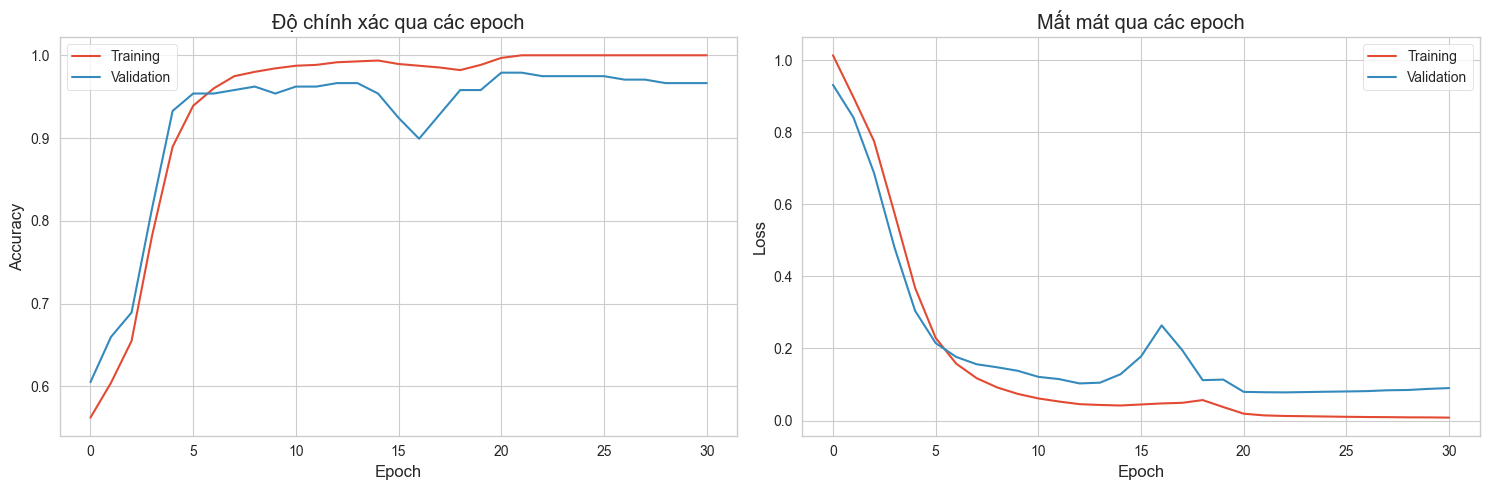

In [11]:
# Vẽ biểu đồ độ chính xác và mất mát
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Đồ thị độ chính xác
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Độ chính xác qua các epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Đồ thị mất mát
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Mất mát qua các epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 7. Đánh giá mô hình


Đã tải mô hình tốt nhất.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Báo cáo phân loại:
              precision    recall  f1-score   support

     resting       0.95      0.88      0.91        59
     sitting       1.00      1.00      1.00        59
     walking       0.96      0.98      0.97       179

    accuracy                           0.97       297
   macro avg       0.97      0.95      0.96       297
weighted avg       0.97      0.97      0.97       297



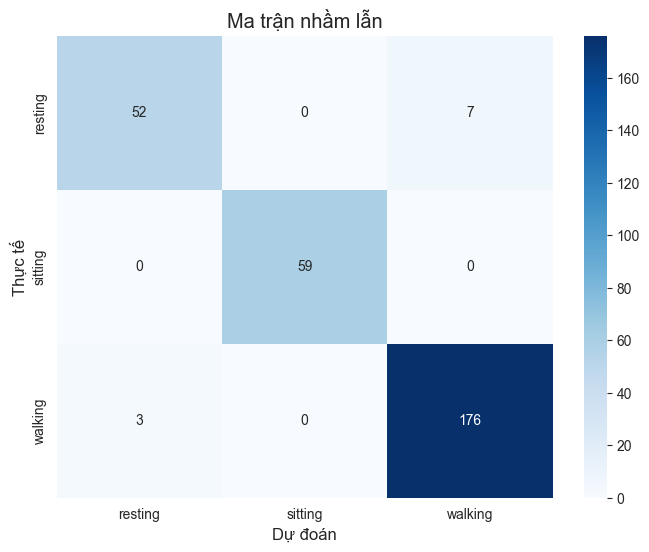

In [12]:
# Tải mô hình tốt nhất nếu đã lưu
try:
    model = load_model('best_model.h5')
    print("Đã tải mô hình tốt nhất.")
except:
    print("Không tìm thấy mô hình đã lưu, sử dụng mô hình hiện tại.")

# Đánh giá trên tập kiểm tra
y_pred = np.argmax(model.predict(X_test), axis=1)

# In báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

## 8. Dự đoán mẫu kiểm tra

Lấy 5 mẫu từ mỗi lớp để kiểm tra mô hình.


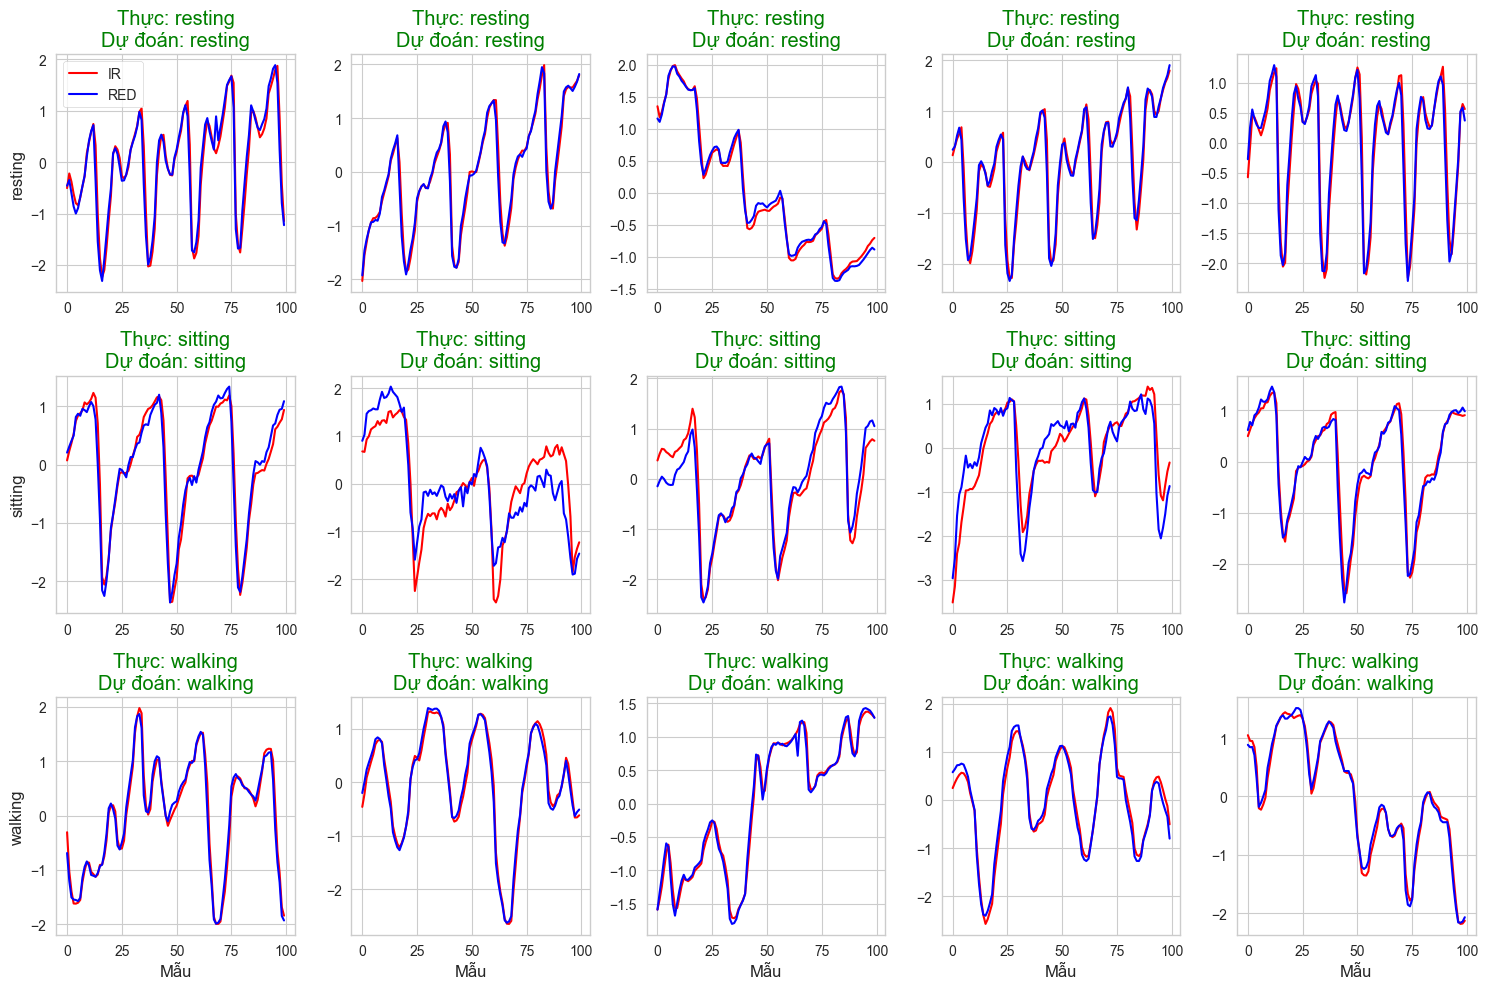

In [13]:
def test_random_samples(model, X, y, label_encoder, n_samples=5):
    """Kiểm tra mô hình với n_samples mẫu ngẫu nhiên từ mỗi lớp"""
    classes = np.unique(y)
    plt.figure(figsize=(15, 10))

    for i, cls in enumerate(classes):
        # Lấy chỉ mục của các mẫu thuộc lớp này
        idx = np.where(y == cls)[0]

        # Chọn ngẫu nhiên n_samples mẫu
        if len(idx) < n_samples:
            samples_idx = idx
        else:
            samples_idx = np.random.choice(idx, n_samples, replace=False)

        # Dự đoán cho mỗi mẫu
        for j, sample_idx in enumerate(samples_idx):
            sample = X[sample_idx:sample_idx+1]
            y_true = y[sample_idx]
            y_pred = np.argmax(model.predict(sample, verbose=0))

            # Vẽ đồ thị
            plt.subplot(len(classes), n_samples, i*n_samples + j + 1)
            plt.plot(sample[0, :, 0], 'r-', label='IR')
            plt.plot(sample[0, :, 1], 'b-', label='RED')

            correct = y_true == y_pred
            color = 'green' if correct else 'red'
            title = f"Thực: {label_encoder.classes_[y_true]}\nDự đoán: {label_encoder.classes_[y_pred]}"
            plt.title(title, color=color)

            if j == 0:
                plt.ylabel(label_encoder.classes_[cls])
            if i == len(classes) - 1:
                plt.xlabel('Mẫu')

            if i == 0 and j == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()


# Kiểm tra mô hình với 5 mẫu ngẫu nhiên từ mỗi lớp
test_random_samples(model, X_test, y_test, label_encoder, n_samples=5)

## 9. Tối ưu hóa kích thước mô hình

Thực hiện các tối ưu hóa để đảm bảo mô hình vẫn đáp ứng yêu cầu về bộ nhớ.


In [14]:
# Bước 1: Chuyển đổi sang dạng uint8 để giảm kích thước
def convert_model_to_int8(model, X_test):
    """Chuyển đổi mô hình sang dạng int8 để giảm kích thước"""
    # Chuyển đổi model sang TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Đặt đại diện của dữ liệu để chuyển đổi
    def representative_dataset_gen():
        for i in range(min(100, len(X_test))):
            yield [X_test[i:i+1].astype(np.float32)]

    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model = converter.convert()

    # Lưu mô hình TFLite
    with open('model_int8.tflite', 'wb') as f:
        f.write(tflite_model)

    print(f"Kích thước mô hình int8: {len(tflite_model) / 1024:.2f} KB")
    return tflite_model

# Bước 2: Tính toán số lượng tham số và kích thước bộ nhớ


def analyze_model_size(model):
    """Phân tích kích thước mô hình"""
    # Tính số lượng tham số
    total_params = count_params(model)

    # Tính kích thước bộ nhớ (giả sử float32 = 4 bytes)
    float32_size_bytes = total_params * 4

    # Tính số lượng objects uint32_t trong giới hạn bộ nhớ
    max_objects = 3000
    uint32_per_object = 3
    max_params = max_objects * uint32_per_object

    print(f"Tổng số tham số: {total_params:,}")
    print(f"Kích thước bộ nhớ (float32): {float32_size_bytes / 1024:.2f} KB")
    print(f"Giới hạn bộ nhớ: {max_params:,} tham số")

    if total_params <= max_params:
        print(
            f"✅ Mô hình nằm trong giới hạn bộ nhớ: {total_params:,} <= {max_params:,}")
    else:
        print(
            f"❌ Mô hình vượt quá giới hạn bộ nhớ: {total_params:,} > {max_params:,}")
        excess = total_params - max_params
        print(
            f"   Vượt quá: {excess:,} tham số ({excess / max_params * 100:.2f}%)")


# Phân tích kích thước mô hình hiện tại
analyze_model_size(model)

# Chuyển đổi và lưu mô hình sang định dạng int8
try:
    tflite_model = convert_model_to_int8(model, X_test)
    print("Đã chuyển đổi và lưu mô hình sang định dạng int8 thành công.")
except Exception as e:
    print(f"Lỗi khi chuyển đổi mô hình: {e}")

Tổng số tham số: 5,957
Kích thước bộ nhớ (float32): 23.27 KB
Giới hạn bộ nhớ: 9,000 tham số
✅ Mô hình nằm trong giới hạn bộ nhớ: 5,957 <= 9,000
INFO:tensorflow:Assets written to: C:\Users\phamb\AppData\Local\Temp\tmpe7pi1dvc\assets


INFO:tensorflow:Assets written to: C:\Users\phamb\AppData\Local\Temp\tmpe7pi1dvc\assets


Saved artifact at 'C:\Users\phamb\AppData\Local\Temp\tmpe7pi1dvc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1532574763488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574768416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574845232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574849984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574857200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574993568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574998144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574996208: TensorSpec(shape=(), dtype=tf.resource, name=None)


d:\Deadline\Nhung\OxiSensor\myenv\lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Kích thước mô hình int8: 12.73 KB
Đã chuyển đổi và lưu mô hình sang định dạng int8 thành công.


## 10. Xuất mô hình và tham số

Xuất mô hình để có thể sử dụng trong môi trường nhúng.


In [15]:
import tensorflow as tf

model_name = "model_esp8266"
header_file = f"{model_name}.h"

# Convert Keras to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

# Tạo .h từ tflite
with open(header_file, "w") as f:
    f.write(f"#ifndef {model_name.upper()}_H\n")
    f.write(f"#define {model_name.upper()}_H\n\n")

    f.write("const unsigned char g_model[] = {\n")
    for i, byte in enumerate(tflite_model):
        if i % 12 == 0:
            f.write("  ")
        f.write(f"0x{byte:02x}, ")
        if (i + 1) % 12 == 0:
            f.write("\n")
    f.write("\n};\n")
    f.write(f"const int g_model_len = {len(tflite_model)};\n\n")

    f.write(f"#endif // {model_name.upper()}_H\n")

print(f"✅ Header model saved to {header_file}")

INFO:tensorflow:Assets written to: C:\Users\phamb\AppData\Local\Temp\tmp6d_l6ymi\assets


INFO:tensorflow:Assets written to: C:\Users\phamb\AppData\Local\Temp\tmp6d_l6ymi\assets


Saved artifact at 'C:\Users\phamb\AppData\Local\Temp\tmp6d_l6ymi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1532574763488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574768416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574845232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574849984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574857200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574993568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574998144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532574996208: TensorSpec(shape=(), dtype=tf.resource, name=None)


✅ Header model saved to model_esp8266.h


## 11. Tổng kết

Trong notebook này, chúng ta đã:

1. Phân tích và hiểu dữ liệu từ cảm biến (IR và RED)
2. Tiền xử lý dữ liệu để chuẩn bị cho việc huấn luyện mô hình
3. Xây dựng mô hình CNN 1D phù hợp với giới hạn bộ nhớ (3000 object)
4. Huấn luyện và đánh giá mô hình trên dữ liệu kiểm tra
5. Tối ưu hóa mô hình bằng cách chuyển đổi sang int8 để giảm kích thước
6. Xuất mô hình để có thể triển khai trên các thiết bị nhúng

Mô hình đã được tạo có thể phân loại chính xác trạng thái của người dùng (nghỉ ngơi, ngồi, đi bộ) dựa trên dữ liệu cảm biến. Tham số mô hình đã được giới hạn để có thể chạy trên các thiết bị có bộ nhớ hạn chế như ESP32 hoặc Arduino.
